In [1]:
#1
import numpy as np
%pylab 
style.use('ggplot')
rcParams['figure.figsize'] = (7,7)
from numba import jit

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>"))
import copy
import networkx as nx

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
#2
#TODO: Implement different random connectivity matrix to make loops more or less probable
#Here we construct a random connectivity matrix (single-directional map)
def getRandomConnectivity(N, pct_connected):
    #Directed mapping
    M = np.random.rand(N**2).reshape(N,N)
    for i in range(N):
        for j in range(N):
            if (i == j):
                M[i,j] = 0
            else:
                if (M[i,j] < pct_connected):
                    M[i,j] = 1 #i connects to j
                else:
                    M[i,j] = 0
    return M

# alternate version
def getRandomConnectivity2(N, pct_connected):
    # There are N*(N-1)/2 upper diagonal elements
    rand_elems = np.where(np.random.rand(N*(N-1)/2) < pct_connected, 1, 0)
    M = np.zeros((N,N))
    M[np.triu_indices(N,1)] = rand_elems
    return M + M.T

# Original version with bidirectional mapping 
def getRandomConnectivity3(N, pct_connected):
    # There is no self coupling so the diagonal must be zero. 
    # The graph is non directed so M must be symmetric
    M = np.random.rand(N**2).reshape(N,N)
    for i in range(N):
        for j in range(i, N):
            if (i == j):
                M[i,j] = 0
            else:
                if (M[i,j] < pct_connected):
                    M[i,j] = 1
                else:
                    M[i,j] = 0
                M[j,i] = M[i,j]
    return M

In [3]:
#3
# algorithm for finding k cores
# The basic idea is to recursively remove nodes of connectivity < k until we either have nothing to remove or no nodes left

def hasKcore(M, k):
    # we'll be destroying the array so make a copy to work with
    X = M.copy()
    while(True):
        cur_num_nodes = X.shape[0]
        s = np.sum(X, 0)
        nodes_to_delete = np.where(s < k)[0]
        if (len(nodes_to_delete) == cur_num_nodes):
            # nothing has at least k connections
            
            X = np.delete(X, nodes_to_delete, axis=0)
            X = np.delete(X, nodes_to_delete, axis=1)
            
            return False
            break
        elif (len(nodes_to_delete) == 0):
            # They all have at least k connections, we've found a kcore
            return True
            break
        else:
            X = np.delete(X, nodes_to_delete, axis=0)
            X = np.delete(X, nodes_to_delete, axis=1)

            
# TODO get Kcore indices 

def largestKcore(M):
    # we can begin the search at the least connected node
    connectivity = np.sum(M,0)
    min_kcore = np.min(connectivity)
    max_kcore = np.max(connectivity)
    if max_kcore == 0:
        return 0
    k = min_kcore
    while (hasKcore(M,k)):
        k = k+1
        
    return k - 1
        
    
    
def largestkcore(M):
    # we can begin the search at the least connected node
    connectivity = np.sum(M,0)
    min_kcore = np.min(connectivity)
    max_kcore = np.max(connectivity)
    if max_kcore == 0:
        return 0
    k = min_kcore
    s=1
    while (s==1):
        
        X = M.copy()
        while(True):
            cur_num_nodes = X.shape[0]
            s = np.sum(X, 0)
            nodes_to_delete = np.where(s < k)[0]
            if (len(nodes_to_delete) == cur_num_nodes):
            # nothing has at least k connections
            
                X = np.delete(X, nodes_to_delete, axis=0)
                X = np.delete(X, nodes_to_delete, axis=1)
            
                s=0
                break
            elif (len(nodes_to_delete) == 0):
            # They all have at least k connections, we've found a kcore
                s=1
                break
            else:
                X = np.delete(X, nodes_to_delete, axis=0)
                X = np.delete(X, nodes_to_delete, axis=1)
        k = k+1
        
    return k - 1

#TODO: Instead of deleting nodes, put 0's on all the connections for the rows and columns that are disconnected
    #Keeps number of all neurons the same so that neuron 3 doesnt become neuron 2 etc. 
    #Look for neurons not in Kcore which are firing and neurons that are in kcore and not firing. 
def kcoreitself(M, k):
    # we'll be destroying the array so make a copy to work with
    X = M.copy()
    
    while(True):
        cur_num_nodes = X.shape[0]
        s = np.sum(X, 0)
        nodes_to_delete = np.where(s < k)[0]
        if (len(nodes_to_delete) == cur_num_nodes):
            
            X = np.delete(X, nodes_to_delete, axis=0)
            X = np.delete(X, nodes_to_delete, axis=1)
            # nothing has at least k connections
            return X
            break
        elif (len(nodes_to_delete) == 0):
            # They all have at least k connections, we've found a kcore
            return X
            break
        else:
            X = np.delete(X, nodes_to_delete, axis=0)
            X = np.delete(X, nodes_to_delete, axis=1)



#here we get the largest connected component of  the graph

def largestcomponent(l,N):
    n=np.random.randint(0,N)
    
    boundary=[n]
    b=1
    comp=[n]
    c=1
   
    while(b>0):
        a=boundary.pop()
        
        oldvertex=int(a)
        
        deg=l[oldvertex,0]
        degree=int(deg)
        #print(degree)
        for j in range(degree):
            newvertex=l[oldvertex,j+1]
            q=comp.count(newvertex)
            #print(newvertex)
            q=int(q)
            #print(q)
            if (q==0):
                comp.append(newvertex)
                boundary.append(newvertex)
                #print(newvertex)
                #print(boundary)
            
        b=len(boundary)
            
    #sizeofcomp=len(comp)
    return(comp)

def matrixOfEdges(M,N):
    N = int(N)
    E=np.zeros(N**2).reshape(N,N)  #prepare array with zeros
    k=np.sum(M,0) #array with degree of each vertex
    for i in range(N):
        a=int(k[i]) #degree of the current vertex
        E[i,0]=a  #we put it to the zero row of matrix of edges
    for i in range(N):
        a=int(k[i])
        q=1
        for j in range(N):
            if (M[j,i]==1):
                E[i,q]=j #all the next elements in current column are number of vertices current vertex is connected to
                q=q+1
    return(E)

In [22]:
def simdyn(M,l,params):
    return simDynamics(M,l,params)

@jit(nopython=True)
def simDynamics(M,l,params):
    N=int(params[0])
    n=int(params[1])
    dt=params[2]
    tauv=params[3]
    tauc=params[4]
    Vstar=params[5]
    Cstar=params[6]
    delV=params[7]
    delC=params[8]
    r=params[9]
    V0=params[10]
    C0=params[11]
    V=zeros(N*n).reshape(N,n)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N*n).reshape(N,n)
    P=zeros(n)  # function P(V), sigmoid
    sump=zeros(n)  #sum of P over the vertices
    avV=zeros(N) #average potencial
    avC=zeros(N)  #average calcium
    #res = int(params[12]) #resulting classification 
    
    for i in range(n):
        V[0,i]=V0 #initial conditions
        C[0,i]=C0 
        avV[0]=n*V0  #we will divide to n later
        avC[0]=n*C0
    for i in range (N-1):
        for j in range(n):
            P[j] = 1/(1+exp((Vstar-V[i,j])*0.2))
        for j in range(n):
            a=int(l[j,0])
            for k in range(a):
                b=int(l[j,k])
                sump[j]=sump[j]+P[b]  #if neuron connected to j-th neuron it participates in sum
        for j in range(n):
            V[i+1,j]=(-V[i,j]/tauv + delV*r*sump[j]*(1/(1+exp(C[i,j]-Cstar))) )*dt + V[i,j]
            C[i+1,j]=(-C[i,j]/tauc + delC*r*sump[j])*dt + C[i,j]
            avC[i+1]=avC[i+1]+C[i+1,j]
            avV[i+1]=avV[i+1]+V[i+1,j]
        for j in range(n):
            sump[j]=0
    for i in range (N):
        avC[i]=avC[i]/n
        avV[i]=avV[i]/n
        
   
    return(avC,avV,C,V)

### Phase Diagram

In [57]:
p = 0.95
n=100 #100
M=getRandomConnectivity(n,p) #args(n,p)
l=matrixOfEdges(M,n)

In [61]:
N=10000
dt=0.001
T=zeros(N)
for i in range(N):
    T[i]=i*dt


M_prime = copy.deepcopy(M)
l_prime = copy.deepcopy(l)
#curr_n = n #Current number of neurons in network 
to_cull = 0

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #15
V0=18 #18
C0=18 #18

delV= 1. #1.2
delVmin = delV/3
delC= 0.015 #0.015
r= 70 #70

params=zeros(12)
params[0]=N
params[1]=n
params[2]=dt
params[3]=tauv
params[4]=tauc
params[5]=Vstar
params[6]=Cstar
params[7]=delV
params[8]=delC
params[9]=r
params[10]=V0
params[11]=C0

phasen = []
phaseV = []
kCore = []

dV = 0.1
delVmax = 15.

while True:
    C,V,c_arr,v_arr = simdyn(M_prime,l_prime,params)
    check = classify(V,params)
    while True:
        #import pdb; pdb.set_trace()
        params[1] -= 1
        #curr_n = curr_n-1
        to_cull += 1
        M_prime = killNeuron2(to_cull, M)
        l_prime = matrixOfEdges(M_prime, params[1])
        if params[1] <= 1:
            params[7] += dV
            params[1] = n
            to_cull = 0
            M_prime = copy.deepcopy(M)
            l_prime = copy.deepcopy(l)
            #curr_n = n
            break
        C,V,c_arr,v_arr = simdyn(M_prime,l_prime,params)
        check2 = classify(V,params)
        if check2 != check:
            print("delV: ", params[7])
            print("transition from", check, "to", check2)
            phasen.append(params[1])
            phaseV.append(params[7])
            params[7] += dV
            '''
            if params[1] < n-3:
                to_cull -= 3
                params[1] += 3 #Changed from params[1] = n to track boundary 
                M_prime = killNeuron2(to_cull, M)
                l_prime = matrixOfEdges(M_prime, params[1])
            '''
            #else:
            to_cull = 0
            params[1] = n 
            M_prime = copy.deepcopy(M)
            l_prime = copy.deepcopy(l)
                
            break

    if params[7] > delVmax:
        break
print('loop complete')

delV:  1.0
transition from 1 to 2
delV:  1.1
transition from 1 to 2
delV:  1.2000000000000002
transition from 1 to 3
delV:  1.3000000000000003
transition from 1 to 3
delV:  1.4000000000000004
transition from 1 to 3
delV:  1.5000000000000004
transition from 1 to 3
delV:  1.6000000000000005
transition from 1 to 3
delV:  1.7000000000000006
transition from 1 to 3
delV:  1.8000000000000007
transition from 1 to 3
delV:  1.9000000000000008
transition from 1 to 3
delV:  2.000000000000001
transition from 1 to 3
delV:  2.100000000000001
transition from 1 to 3
delV:  2.200000000000001
transition from 1 to 3
delV:  2.300000000000001
transition from 1 to 3
delV:  2.4000000000000012
transition from 1 to 3
delV:  2.5000000000000013
transition from 1 to 3
delV:  2.6000000000000014
transition from 1 to 3
delV:  2.7000000000000015
transition from 1 to 3
delV:  2.8000000000000016
transition from 1 to 3
delV:  2.9000000000000017
transition from 1 to 3
delV:  3.0000000000000018
transition from 1 to 3
delV:

KeyboardInterrupt: 

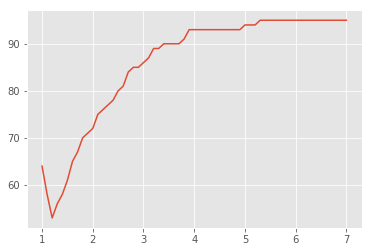

In [62]:
plot(phaseV,phasen)

### Dynamics for specific parameters

In [123]:
N=100000
n=100 #100
dt=0.001
T=zeros(N)
for i in range(N):
    T[i]=i*dt
p = 0.9

M_prime = copy.deepcopy(M)
l_prime = copy.deepcopy(l)
#curr_n = n #Current number of neurons in network 

target_n = 53
to_cull = n-target_n

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #15
V0=18 #18
C0=18 #18

delV= 1.2 #1.2
delC= 0.015 #0.015
r= 70 #70

params=zeros(12)
params[0]=N
params[1]=target_n
params[2]=dt
params[3]=tauv
params[4]=tauc
params[5]=Vstar
params[6]=Cstar
params[7]=delV
params[8]=delC
params[9]=r
params[10]=V0
params[11]=C0

M_prime = killNeuron2(to_cull, M)
l_prime = matrixOfEdges(M_prime, params[1])

C,V,c_arr,v_arr=simdyn(M_prime, l_prime, params)

In [125]:
print(Vstar)
firing = 0
for i in range(len(v_arr[-1])):
    if v_arr[-1,i] > Vstar and c_arr[-1,i] < Cstar:
        firing += 1
        
print("total neurons: {} \ntotal firing neurons: {}".format(target_n, firing))

15
total neurons: 53 
total firing neurons: 48


Text(0.5, 1.0, '3')

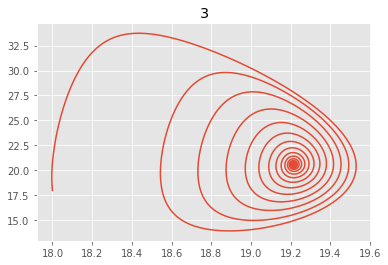

In [124]:
plot(C,V)
title(classify(V,params))

In [126]:
largestkcore(M_prime)

47.0

In [136]:
x=kcoreitself(M_prime,46)

In [138]:
x.shape

(53, 53)

In [9]:
def simdyn2(M,l,params):
    return simDynamics2(M,l,params)

@jit(nopython=True)
def simDynamics2(M,l,params):
    N=int(params[0])
    n=int(params[1])
    dt=params[2]
    tauv=params[3]
    tauc=params[4]
    Vstar=params[5]
    Cstar=params[6]
    delV=params[7]
    delC=params[8]
    r=params[9]
    V0=params[10]
    C0=params[11]
    V=zeros(N*n).reshape(N,n)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N*n).reshape(N,n)
    P=zeros(n)  # function P(V), sigmoid
    sump=zeros(n)  #sum of P over the vertices
    avV=zeros(N) #average potencial
    avC=zeros(N)  #average calcium
    #res = int(params[12]) #resulting classification 
    
    for i in range(n):
        V[0,i]=V0 #initial conditions
        C[0,i]=C0 
        avV[0]=n*V0  #we will divide to n later
        avC[0]=n*C0
    for i in range (N-1):
        for j in range(n):
            if V[i,j] < Vstar:
                P[j] = 0 #5
            else: 
                P[j] = 70 #70
        for j in range(n):
            a=int(l[j,0])
            for k in range(a):
                b=int(l[j,k])
                sump[j]=sump[j]+P[b]  #if neuron connected to j-th neuron it participates in sum
            
        #pull conditionals to next loop
        for j in range(n):
            if V[i,j] < Vstar:
                r = 0 #5
            else:
                r = 70 #250
            if C[i,j] < Cstar: 
                delV = params[7]
                #delC = params[8]
            else:
                delV = .1*params[7] #0
                #delC = 0.0005
                
            V[i+1,j]=(-V[i,j]/tauv + sump[j]*delV*r)*dt + V[i,j] 
            C[i+1,j]=(-C[i,j]/tauc + sump[j]*delC*r)*dt + C[i,j]
            avC[i+1]=avC[i+1]+C[i+1,j]
            avV[i+1]=avV[i+1]+V[i+1,j]
        for j in range(n):
            sump[j]=0
    for i in range (N):
        avC[i]=avC[i]/n
        avV[i]=avV[i]/n
        
   
    return(avC,avV)

In [10]:
#4
#here we define the simulation process for random matrix. It is longer for numerical point of view so we use @jit compiler which significantly accelerates it 
import pdb
#for some reason we need this funky embedding
def simdyn3(M, l, params):
    return simDynamics3(M, l, params)



#@jit(nopython=True)
def simDynamics3(M, l, params):  #params is a vector of parameters
    N=int(params[0])
    n=int(params[1])
    dt=params[2]
    tauv=params[3]
    tauc=params[4]
    Vstar=params[5]
    Cstar=params[6]
    delV=params[7]
    delC=params[8]
    r=params[9]
    V0=params[10]
    C0=params[11]
    delVmin = params[12]
    V=zeros(N*n).reshape(N,n)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N*n).reshape(N,n)
    #P=zeros(n)  # function P(V), sigmoid
    P = zeros(N*n).reshape(N,n)
    deltaV=zeros(n)
    sump=zeros(n)  #sum of P over the vertices
    avV=zeros(N) #average potencial
    avC=zeros(N)  #average calcium
    firing_neurons_count = zeros(N*n).reshape(N,n) #Individually count how may neurons are actually firing in this model at a given step N.
    
    for i in range(n):
        V[0,i]=V0 #initial conditions
        C[0,i]=C0 
        if V[0,i] > Vstar: #keep track of and return how many neurons in the network are actually firing  
            firing_neurons_count[0,i] = 1
        avV[0]=n*V0  #we will divide to n later
        avC[0]=n*C0
    for i in range (N-1):
        for j in range(n):
            if (V[i,j]>Vstar): #V[i,j] stores voltage of each neuron instead of returning the average voltage 
                P[i,j]=70
            else:
                P[i,j]=0
            if (C[i,j]<Cstar):
                deltaV[j]=delV #change from 1.2 
            else:
                deltaV[j]=delVmin #changed from .4
        for j in range(n):
            a=int(l[j,0]) #a should give number of firing neighbors 
            for k in range(a):
                #b=int(l[j,k])
                b = int(l[j,k+1])
                sump[j]=sump[j]+P[i,b]  #if neuron connected to j-th neuron it participates in sum
        for j in range(n):
            V[i+1,j]=(-V[i,j]/tauv + deltaV[j]*sump[j])*dt + V[i,j]
            if V[i+1,j] > Vstar: 
                firing_neurons_count[i+1,j] = 1 #used to return count of firing neurons later
            if ((firing_neurons_count[i,j] == 1) and (firing_neurons_count[i+1,j] == 0)):
                print(sump[j])
            C[i+1,j]=(-C[i,j]/tauc + delC*r*sump[j])*dt + C[i,j]
            avC[i+1]=avC[i+1]+C[i+1,j]
            avV[i+1]=avV[i+1]+V[i+1,j]
        for j in range(n):
            sump[j]=0
    for i in range (N):
        avC[i]=avC[i]/n
        avV[i]=avV[i]/n
        
        #plot([avC[i],avC[i+1]],[avV[i],avV[i+1]])    
    return(avC,avV, firing_neurons_count, P, V)

In [11]:
#5
#TODO: Implement Fourier Analysis for classification
    #Compare activity of one neuron with the results of classification graph 
###Classification 1 : Simple###
def classify(V, params):
    #Set up some globals 
    
    N = int(params[0])
    n = int(params[1])
    
    #Network uniformly connected but vectorized lets us scale later 
    #for i in range (N/2, N):
    max_V = max(V[int(N/2):N])
    min_V = min(V[int(N/2):N])
   
            
    V_delta = max_V - min_V
    
    if V_delta < 0.1: #changed from 1
        if V[N-1] < 15:
            #params[12] = 2
            return 2
        else:
            #params[12] = 3
            return 3
    else:
        #params[12] = 1
        return 1

In [12]:
#6
#Removes one neuron from the network (cull an x,y axis). 
def killNeuron(N,M_prime):
    M = copy.deepcopy(M_prime)
    #Randomly pick a neuron to remove
    #x = np.random.randint(N)
    x = 1
    M = np.delete(M,x,axis=0)
    M = np.delete(M,x,axis=1)
    return M

#TODO: Kill N neurons from the network systematically instead of one at a time. 
def killNeuron2(to_cull, M_prime):
    M = copy.deepcopy(M_prime) 
    #Systemically cull certain neuron from the matrix
    x = 0    
    for i in range (int(to_cull)):
        M = np.delete(M,x,axis=0)
        M = np.delete(M,x,axis=1)
    return M

Iterate from the right with classification algorithm 
        1. ONLY decrement neuron count.
        2. Append to right array 
        3. When hit 0 break
    5. Start algorithm from the left (steps 1-3), appending to left array
    6. Reverse right array and append to left array for end result. 

In [9]:
#7
### Run this one after running matrix cells and the cell for simdyn3 
N=10000
n=100 #100
dt=0.001
T=zeros(N)
for i in range(N):
    T[i]=i*dt
p = 1/6 #Connectivity rate High connectivity is just mean field so it looks a lot smoother... want to maybe not make it so high

M=getRandomConnectivity(n,p) #args(n,p)
l=matrixOfEdges(M,n)
M_prime = copy.deepcopy(M)
l_prime = copy.deepcopy(l)
#curr_n = n #Current number of neurons in network 
to_cull = 0

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #15
V0=18 #18
C0=18 #18

delV= 4. #1.2
delVmin = delV/3
delC= 0.015 #0.015
r= 70 #70

params=zeros(13)
params[0]=N
params[1]=n
params[2]=dt
params[3]=tauv
params[4]=tauc
params[5]=Vstar
params[6]=Cstar
params[7]=delV
params[8]=delC
params[9]=r
params[10]=V0
params[11]=C0
params[12]=delVmin #connenctivity rate from above.


phasen = []
phaseV = []
kCore = []

dV = 0.1
delVmax = 20.

while True:
    C,V,f = simdyn3(M_prime,l_prime,params)
    check = classify(V,params)
    while True:
        #import pdb; pdb.set_trace()
        params[1] -= 1
        #curr_n = curr_n-1
        to_cull += 1
        M_prime = killNeuron2(to_cull, M)
        l_prime = matrixOfEdges(M_prime, params[1])
        if params[1] <= 1:
            params[7] += dV
            params[12] = params[7]/3
            params[1] = n
            to_cull = 0
            M_prime = copy.deepcopy(M)
            l_prime = copy.deepcopy(l)
            #curr_n = n
            break
        C,V,f = simdyn3(M_prime,l_prime,params)
        check2 = classify(V,params)
        if check2 != check:
            print("delV: ", params[7])
            print("transition from", check, "to", check2)
            #print("Kcore: ", largestKcore(M_prime), "Predicted:",floor(Vstar/(tauv*70*params[12])))
            print("Kcore: ", largestKcore(M_prime), "Predicted:",Vstar/(tauv*70*params[12]))
            phasen.append(params[1])
            phaseV.append(params[7])
            kCore.append(largestKcore(M_prime))
            params[7] += dV
            params[12] = params[7]/3
            if params[1] < n-3:
                to_cull -= 3
                params[1] += 3 #Changed from params[1] = n to track boundary 
                M_prime = killNeuron2(to_cull, M)
                l_prime = matrixOfEdges(M_prime, params[1])
            else:
                to_cull = 0
                params[1] = n 
                M_prime = copy.deepcopy(M)
                l_prime = copy.deepcopy(l)
                
            break

    if params[7] > delVmax:
        break
print('loop complete')


1050.0
1120.0
1120.0
1120.0
1120.0
1120.0
1120.0
1120.0
1120.0
1120.0
1120.0
1120.0
1050.0
1120.0


ValueError: too many values to unpack (expected 3)

In [12]:
#8
#TODO: HA to SO phase.... find the k that it needs to bump up
#Plots everything 

if len(phasen) > 0 and len(phaseV) > 0:

    figure(1)
    ylabel('n, number of neurons')
    xlabel('delV')
    yticks(np.arange(0, 150, 5.0))
    grid(color='black', linestyle='dotted', linewidth=1)
    plot(phaseV,phasen, '-o')
    #savefig('kcore_correct2.png')

    figure(2)
    ylabel('largest k core') 
    xlabel('delV') 
    plot(phaseV, kCore, '-0') 
    #savefig('kcore_kcores_correct2.png')
    
else:
    print('no transition')


In [10]:
#Looking at k-core size versus the actual number of firing neurons in the network 
N=1000
n=80 #150
dt=0.001
T=zeros(N)
for i in range(N):
    T[i]=i*dt
p = 1/6 #Connectivity rate High connectivity is just mean field so it looks a lot smoother... want to maybe not make it so high

M=getRandomConnectivity(n,p) #args(n,p)
M_T = transpose(M)
l1=matrixOfEdges(M,n)
l2=matrixOfEdges(M_T,n)
#M_prime = copy.deepcopy(M_T)
#l_prime = copy.deepcopy(l)

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #15
V0=30 #18
C0=30 #18

delV= 8.4 #1.2
delVmin = delV/3
delC= 0.015 #0.015
r= 70 #70

cull_to = 10 #How many neurons we want to cut down to from original matrix 50 worked well
#M_prime = killNeuron2(n-cull_to, M_T)
#l_prime = matrixOfEdges(M_prime, cull_to)

params=zeros(13)
params[0]=N
params[1]=n #instead of actual n, cull neurons til desired value
params[2]=dt
params[3]=tauv
params[4]=tauc
params[5]=Vstar
params[6]=Cstar
params[7]=delV
params[8]=delC
params[9]=r
params[10]=V0
params[11]=C0
params[12]=delVmin #connenctivity rate from above.


#C,V,neuron_counts = simdyn3(M_prime,l_prime,params)
C,V,neuron_counts, P, Voltages = simdyn3(M,l1,params)
itself = kcoreitself(M,ceil(Vstar/(tauv*delVmin*r)))

280.0
490.0


In [11]:
out = Vstar/(tauv*delVmin*r)

print("Classification:",classify(V,params))
print("Largest kcore:", largestKcore(M))
print("Predicted k: ",out)
print("Shape of kcore (gives kcore size):",itself.shape)
print("Number of neurons total in network:",params[1])
print("Number of firing neurons:",sum(neuron_counts[N-1]))

Classification: 3
Largest kcore: 8.0
Predicted k:  7.653061224489795
Shape of kcore (gives kcore size): (78, 78)
Number of neurons total in network: 80.0
Number of firing neurons: 78.0


In [15]:
plt.xlim(0,50)
for i in range(10):
    plt.plot(Voltages[:,i],label=i)
plt.legend()
plt.show()
#plt.savefig("Voltages.png")

In [13]:
plt.xlim(0,50)
for i in range(10):
    plt.plot(P[:,i],label=i)
plt.legend()
#plt.savefig("P.png")

In [278]:
print(shape(kcoreitself(M_T,ceil(Vstar/(tauv*delVmin*r)))))

(10, 10)


In [111]:
print(neuron_counts)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [673]:
#Plots where each neuron stops firing 
plt.xlim(0,100)
for i in range(10):
    plt.plot(neuron_counts[:,i],label="%d"%i)
plt.legend()
plt.savefig("stop_firing.png")

In [674]:
print(neuron_counts[9])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [675]:
#Attempt to visualize network connectivity
#TODO: Check with smaller numbers of neurons and check connectivities. 

#TODO: make red edges point FROM firing neuron. 
G = nx.DiGraph()
H = nx.DiGraph()
G.add_nodes_from(range(0,n))
H.add_nodes_from(range(0,n))
for i in range(n):
    for j in range(n):
        if M[i,j] == 1: #and neuron_counts[N-1,j] == 1:
            #if neuron_counts[N-1,j] == 1:
            if neuron_counts[N-1,i] == 1:
                H.add_edge(i,j,firing=True)
            else:
                G.add_edge(i,j,firing=False)
        


In [676]:
print(l1)
print(int(l1[9,5]))

[[4. 1. 2. 7. 8. 0. 0. 0. 0. 0.]
 [5. 3. 4. 6. 8. 9. 0. 0. 0. 0.]
 [5. 0. 3. 5. 6. 9. 0. 0. 0. 0.]
 [5. 0. 4. 7. 8. 9. 0. 0. 0. 0.]
 [5. 1. 2. 6. 7. 9. 0. 0. 0. 0.]
 [6. 1. 2. 4. 6. 8. 9. 0. 0. 0.]
 [3. 7. 8. 9. 0. 0. 0. 0. 0. 0.]
 [5. 0. 2. 3. 4. 8. 0. 0. 0. 0.]
 [2. 0. 9. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 2. 4. 5. 7. 0. 0. 0. 0.]]
7


[[70. 70. 70. ... 70. 70. 70.]
 [70. 70. 70. ... 70. 70. 70.]
 [70. 70. 70. ... 70. 70. 70.]
 ...
 [70. 70. 70. ... 70. 70.  0.]
 [70. 70. 70. ... 70. 70.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [677]:
print(neuron_counts[N-1])

[1. 1. 1. 1. 1. 1. 0. 1. 0. 1.]


In [678]:
plt.title("%d Neurons in network"%G.order())
nx.draw_circular(H,node_size=20,width=0.3,node_color='black', edge_color='red',with_labels=True)
nx.draw_circular(G,node_size=20,width=0.3,edge_color='black',node_color='black')
plt.savefig('neuron_connectivity.png')

In [679]:
H.edges

OutEdgeView([(0, 2), (0, 3), (0, 7), (0, 8), (0, 9), (1, 0), (1, 4), (1, 5), (2, 0), (2, 4), (2, 5), (2, 7), (2, 9), (3, 1), (3, 2), (3, 7), (4, 1), (4, 3), (4, 5), (4, 7), (4, 9), (5, 2), (5, 9), (7, 0), (7, 3), (7, 4), (7, 6), (7, 9), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 8)])

In [680]:
G.edges

OutEdgeView([(6, 1), (6, 2), (6, 4), (6, 5), (8, 0), (8, 1), (8, 3), (8, 5), (8, 6), (8, 7)])